In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import scipy
from math import ceil
import re

## Load & Clean Data

In [2]:
data = pd.read_csv('/Users/katepoole/Documents/KINGS/~Dissertation/~Data/LLM-perf-leaderboard_2024_0605.csv')

In [3]:
# remove bottom row of NAs
data = data[0:900]

## Exploratory Data Analysis

In [4]:
# summary statistics 
data.describe()

,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),End-to-End (s),Params (B)
count,900.000000,900.000000,900.000000,9.000000e+02,900.000000,900.000000
mean,0.288953,23.439527,6613.429726,5.037026e+05,13.905320,6.264444
std,0.408732,29.537050,5546.502194,7.626412e+05,23.124209,7.067690
min,0.005000,0.378000,178.503000,5.072790e+03,0.302000,0.000000
25%,0.058000,3.637500,1944.678250,4.830142e+04,2.331250,1.000000
50%,0.112000,14.380500,5087.238500,2.945429e+05,4.591000,6.000000
75%,0.340000,28.021250,9462.913000,5.328030e+05,17.629500,8.000000
max,2.805000,211.306000,22557.818000,5.869030e+06,169.522000,34.000000


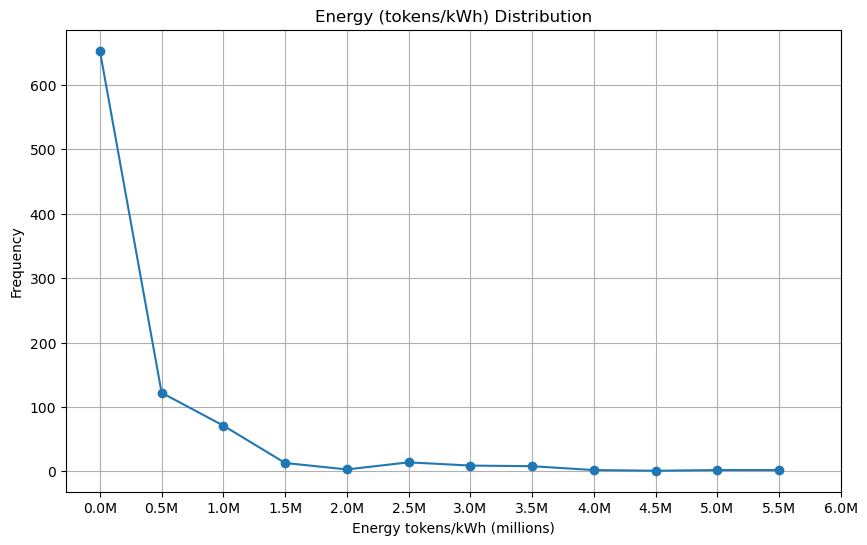

In [5]:
# Bin the data for line chart increments
bins = np.arange(0, data['Energy (tokens/kWh)'].max() + 500000, 500000)
data['Energy_bins'] = pd.cut(data['Energy (tokens/kWh)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
energy_distribution = data['Energy_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
energy_distribution.index = energy_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(energy_distribution.index, energy_distribution.values, marker='o', linestyle='-')
plt.title('Energy (tokens/kWh) Distribution')
plt.xlabel('Energy tokens/kWh (millions)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(0, data['Energy (tokens/kWh)'].max() + 500000, 500000)
xtick_labels = [f'{x/1e6:.1f}M' for x in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.grid(True)
plt.show()

#### Drill down within up to 1M tokens chunk

In [6]:
# Split first bin 0 - 1M for greater granularity 
data_to_1M = data[data['Energy (tokens/kWh)'] <= 1000000]

/var/folders/m6/t786km0s2gj___42n4vm3gnr0000gn/T/ipykernel_52077/1055833360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_1M['Energy_bins'] = pd.cut(data_to_1M['Energy (tokens/kWh)'], bins=bins, labels=bins[:-1])


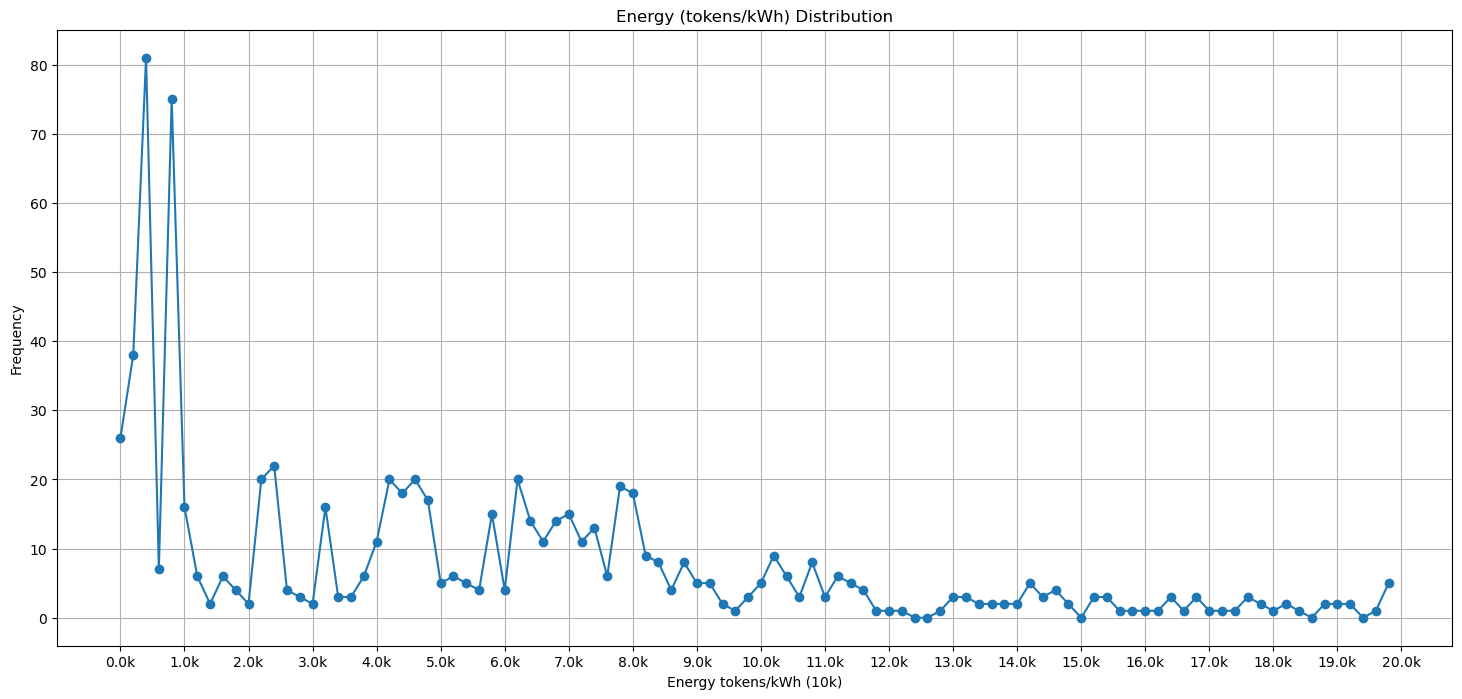

In [7]:
# plot up to 1M data
# Bin the data for the histogram
bins = np.arange(0, data_to_1M['Energy (tokens/kWh)'].max() + 10000, 10000)
data_to_1M['Energy_bins'] = pd.cut(data_to_1M['Energy (tokens/kWh)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
energy_distribution = data_to_1M['Energy_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
energy_distribution.index = energy_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(18, 8))
plt.plot(energy_distribution.index, energy_distribution.values, marker='o', linestyle='-')
plt.title('Energy (tokens/kWh) Distribution')
plt.xlabel('Energy tokens/kWh (10k)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(0, data_to_1M['Energy (tokens/kWh)'].max() + 50000, 50000)
xtick_labels = [f'{x/50000}k' for x in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.grid(True)
plt.show()

In [8]:
data_to_1M[data_to_1M['Energy (tokens/kWh)'] < 10000]

"""
A lot appear to belong to the internlm, huggyllama, and O1-ai models, meaning these are the least efficient models 
Higher tokens/kWh score --> higher efficiency (like mpg)
"""

'\nA lot appear to belong to the internlm, huggyllama, and O1-ai models, meaning these are the least efficient models \nHigher tokens/kWh score --> higher efficiency (like mpg)\n'

In [9]:
# look at the highest energy scores
data[data['Energy (tokens/kWh)'] > 1500000]
"""
All appear associated with low Open LLM scores 
"""

'\nAll appear associated with low Open LLM scores \n'

In [10]:
# Remove * from Open LLM score variable
data['Open LLM Score (stripped)'] = data['Open LLM Score (%)'].str.replace('*','').astype(float)

/var/folders/m6/t786km0s2gj___42n4vm3gnr0000gn/T/ipykernel_52077/3419938314.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Open LLM Score (stripped)'] = data['Open LLM Score (%)'].str.replace('*','').astype(float)


In [11]:
data.head()
# looks good 

,Model,Experiment,Prefill (s),Decode (tokens/s),Memory (MB),Energy (tokens/kWh),Open LLM Score (%),Backend,Precision,Quantization,Attention,Kernel,End-to-End (s),Architecture,Params (B),Energy_bins,Open LLM Score (stripped)
0,internlm/internlm2-20b,4bit-awq-gemm-eager,1.596,0.678,14169.857,9018.305,69.75*,pytorch,float16,AWQ.4bit,Eager,AWQ.GEMM,94.475,Unknown,20.0,0.0,69.75
1,internlm/internlm2-20b,4bit-awq-gemm-fa2,1.584,0.679,14170.905,9125.542,69.75*,pytorch,float16,AWQ.4bit,FAv2,AWQ.GEMM,94.313,Unknown,20.0,0.0,69.75
2,internlm/internlm2-20b,4bit-gptq-exllama-v2-eager,0.913,1.270,13753.433,15682.496,69.75*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV2,50.529,Unknown,20.0,0.0,69.75
3,internlm/internlm2-20b,4bit-gptq-exllama-v1-eager,0.912,1.270,13753.433,15775.310,69.75*,pytorch,float16,GPTQ.4bit,Eager,GPTQ.ExllamaV1,50.529,Unknown,20.0,0.0,69.75
4,internlm/internlm2-20b,4bit-gptq-exllama-v1-fa2,0.903,1.273,13753.432,15849.582,69.75*,pytorch,float16,GPTQ.4bit,FAv2,GPTQ.ExllamaV1,50.399,Unknown,20.0,0.0,69.75


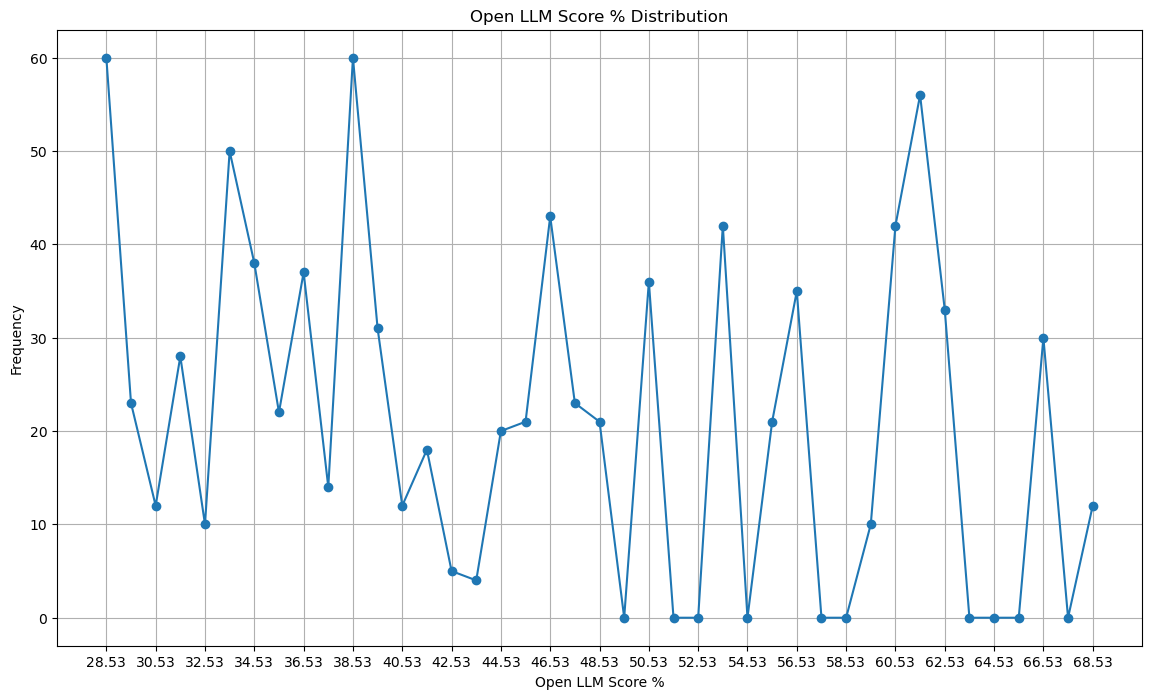

In [12]:
# Bin the data for line chart increments - Open LLM Score
bins = np.arange(data['Open LLM Score (stripped)'].min(), data['Open LLM Score (stripped)'].max(), 1)
data['llm_score_bins'] = pd.cut(data['Open LLM Score (stripped)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
llm_score_distribution = data['llm_score_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
llm_score_distribution.index = llm_score_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(llm_score_distribution.index, llm_score_distribution.values, marker='o', linestyle='-')
plt.title('Open LLM Score % Distribution')
plt.xlabel('Open LLM Score %')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(data['Open LLM Score (stripped)'].min(), data['Open LLM Score (stripped)'].max(), 2)
plt.xticks(ticks=xticks)

plt.grid(True)
plt.show()

Scores are all over the place, vary from 29% to ~69%

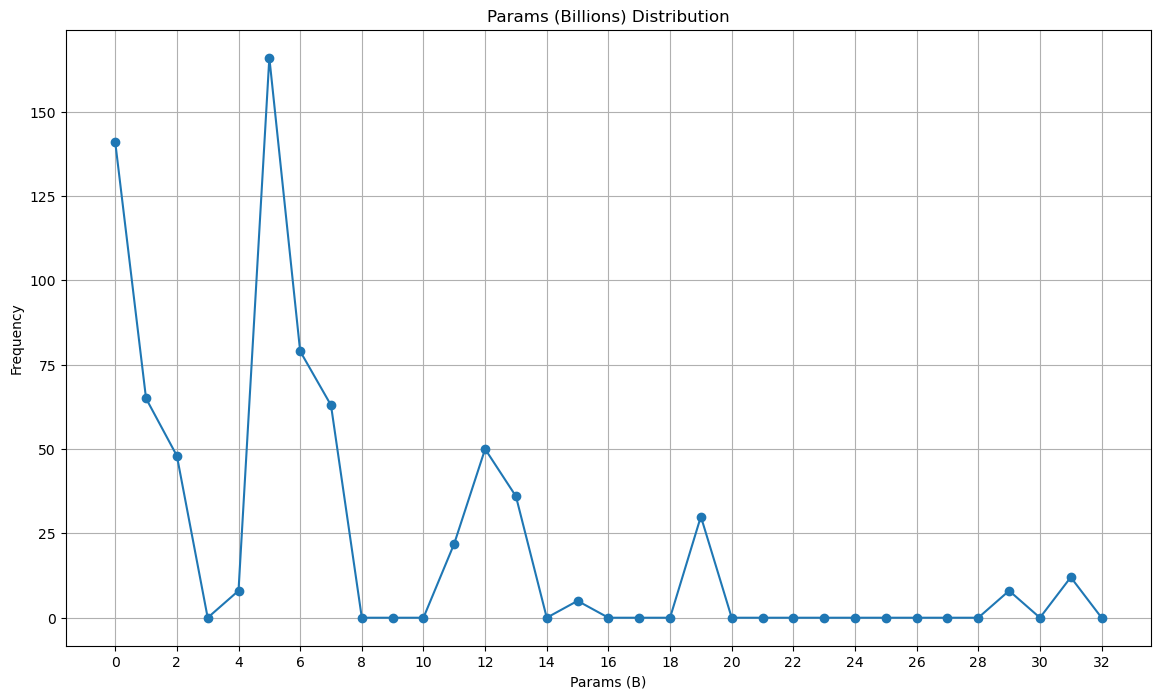

In [13]:
# Bin the data for line chart increments - Params(B)
bins = np.arange(data['Params (B)'].min(), data['Params (B)'].max(), 1)
data['params_bins'] = pd.cut(data['Params (B)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
params_distribution = data['params_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
params_distribution.index = params_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(params_distribution.index, params_distribution.values, marker='o', linestyle='-')
plt.title('Params (Billions) Distribution')
plt.xlabel('Params (B)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(data['Params (B)'].min(), data['Params (B)'].max(), 2)
plt.xticks(ticks=xticks)

plt.grid(True)
plt.show()

Mostly <10b parameters, some at the high end (>28b)

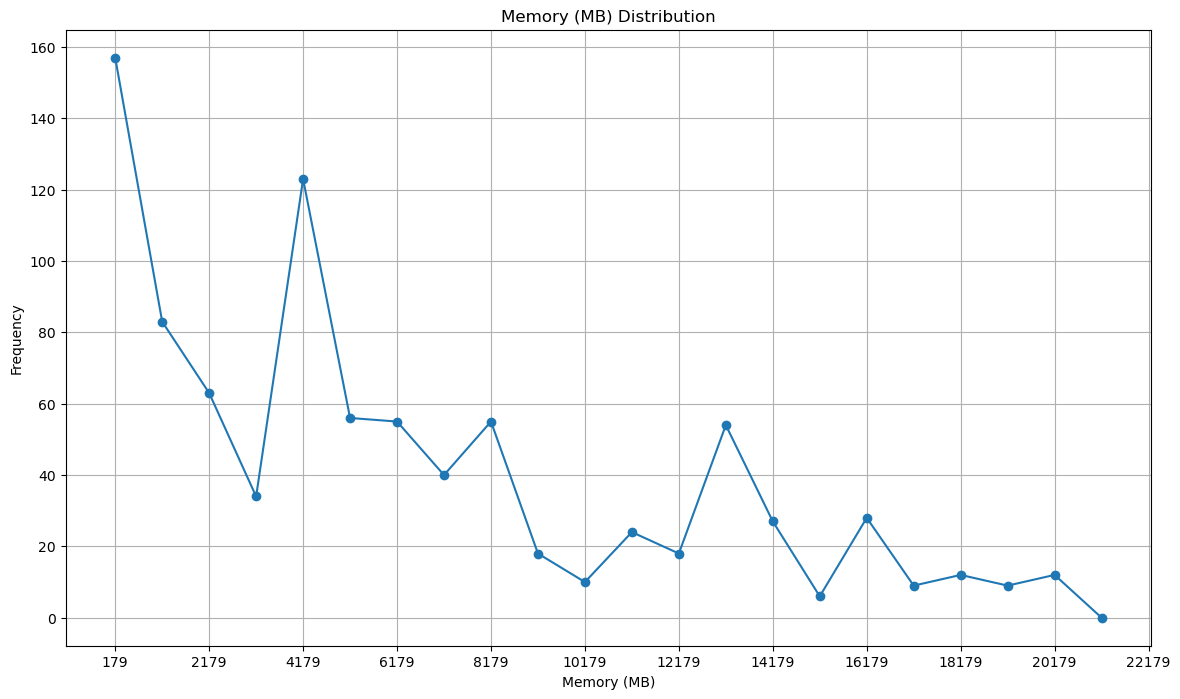

In [14]:
# Bin the data for line chart increments - Memory (MB)
bins = np.arange(data['Memory (MB)'].min(), data['Memory (MB)'].max(), 1000)
data['memory_bins'] = pd.cut(data['Memory (MB)'], bins=bins, labels=bins[:-1])

# Calculate the frequency of each bin
memory_distribution = data['memory_bins'].value_counts().sort_index()

# Convert the index to numeric type for plotting
memory_distribution.index = memory_distribution.index.astype(float)

# Plot the distribution as a line chart using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(memory_distribution.index, memory_distribution.values, marker='o', linestyle='-')
plt.title('Memory (MB) Distribution')
plt.xlabel('Memory (MB)')
plt.ylabel('Frequency')

# Set x-ticks increment to 500,000 and add 'M' to denote millions
xticks = np.arange(data['Memory (MB)'].min(), data['Memory (MB)'].max(), 2000)
plt.xticks(ticks=xticks)

plt.grid(True)
plt.show()

Consistent downwards trend in used Memory

### Skewness scores
Some of the variable distributions appear slightly skewed, let's look at their skewness scores

In [15]:
results=[] 

for col in data.select_dtypes(include=['number']):
    score = scipy.stats.skew(data[col], axis=0, bias=True)
    results.append((col, score))

In [16]:
print('Skewness scores:')

for col, score in results:
    print(f"Column: {col}, Skewness: {score}")

Skewness scores:
Column: Prefill (s), Skewness: 2.902806722779904
Column: Decode (tokens/s), Skewness: 2.77784519977172
Column: Memory (MB), Skewness: 0.8604937277859768
Column: Energy (tokens/kWh), Skewness: 3.3769375913822026
Column: End-to-End (s), Skewness: 3.4723859368642125
Column: Params (B), Skewness: 1.957528428904745
Column: Open LLM Score (stripped), Skewness: 0.301894286498468


Some right sided skewness, keep in mind for analysis. High with 'Energy' and 'End-to-End' variables. Apply normalization to mitigate if needed.

# Scatterplots for variable against variable to discern relationships

In [17]:
# Function that generates scatterplots for each variable against all others
# Inspired by Rggplot funcionality 
def gg_scatterplots(data, y_variable="Energy (tokens/kWh)"):
    # Get all variable names except the y_variable
    #x_variables = [col for col in data.columns if col != y_variable]
    x_variables = [col for col in data.columns if col not in (y_variable, 'Open LLM Score (%)', 'Energy_bins', 'params_bins', 'memory_bins', 'Backend')]

    # Determine the number of rows and columns for the subplots
    n_cols = 3
    n_rows = ceil(len(x_variables) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(x_variables):
        # Create readable labels
        x_label = re.sub(r"[._]", " ", variable).title()
        plot_title = f"{x_label} vs {y_variable}"

        # Create scatter plot 
        sns.scatterplot(x=variable, y=y_variable, data=data, ax=axes[idx], color="royalblue", marker='o')
        # Add tight regression line 
        #sns.lineplot(x=variable, y=y_variable, data=data, ax=axes[idx], color="black", linestyle='dashed')  
        ## remove comment ^ to add regression line

        # Set titles and labels
        axes[idx].set_title(plot_title, fontsize=10)
        axes[idx].set_xlabel(x_label)
        axes[idx].set_ylabel(y_variable)

        # Adjust x-axis ticks for readability
        axes[idx].xaxis.set_major_locator(MaxNLocator(nbins=10))

    # Remove any unused subplots
    for idx in range(len(x_variables), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

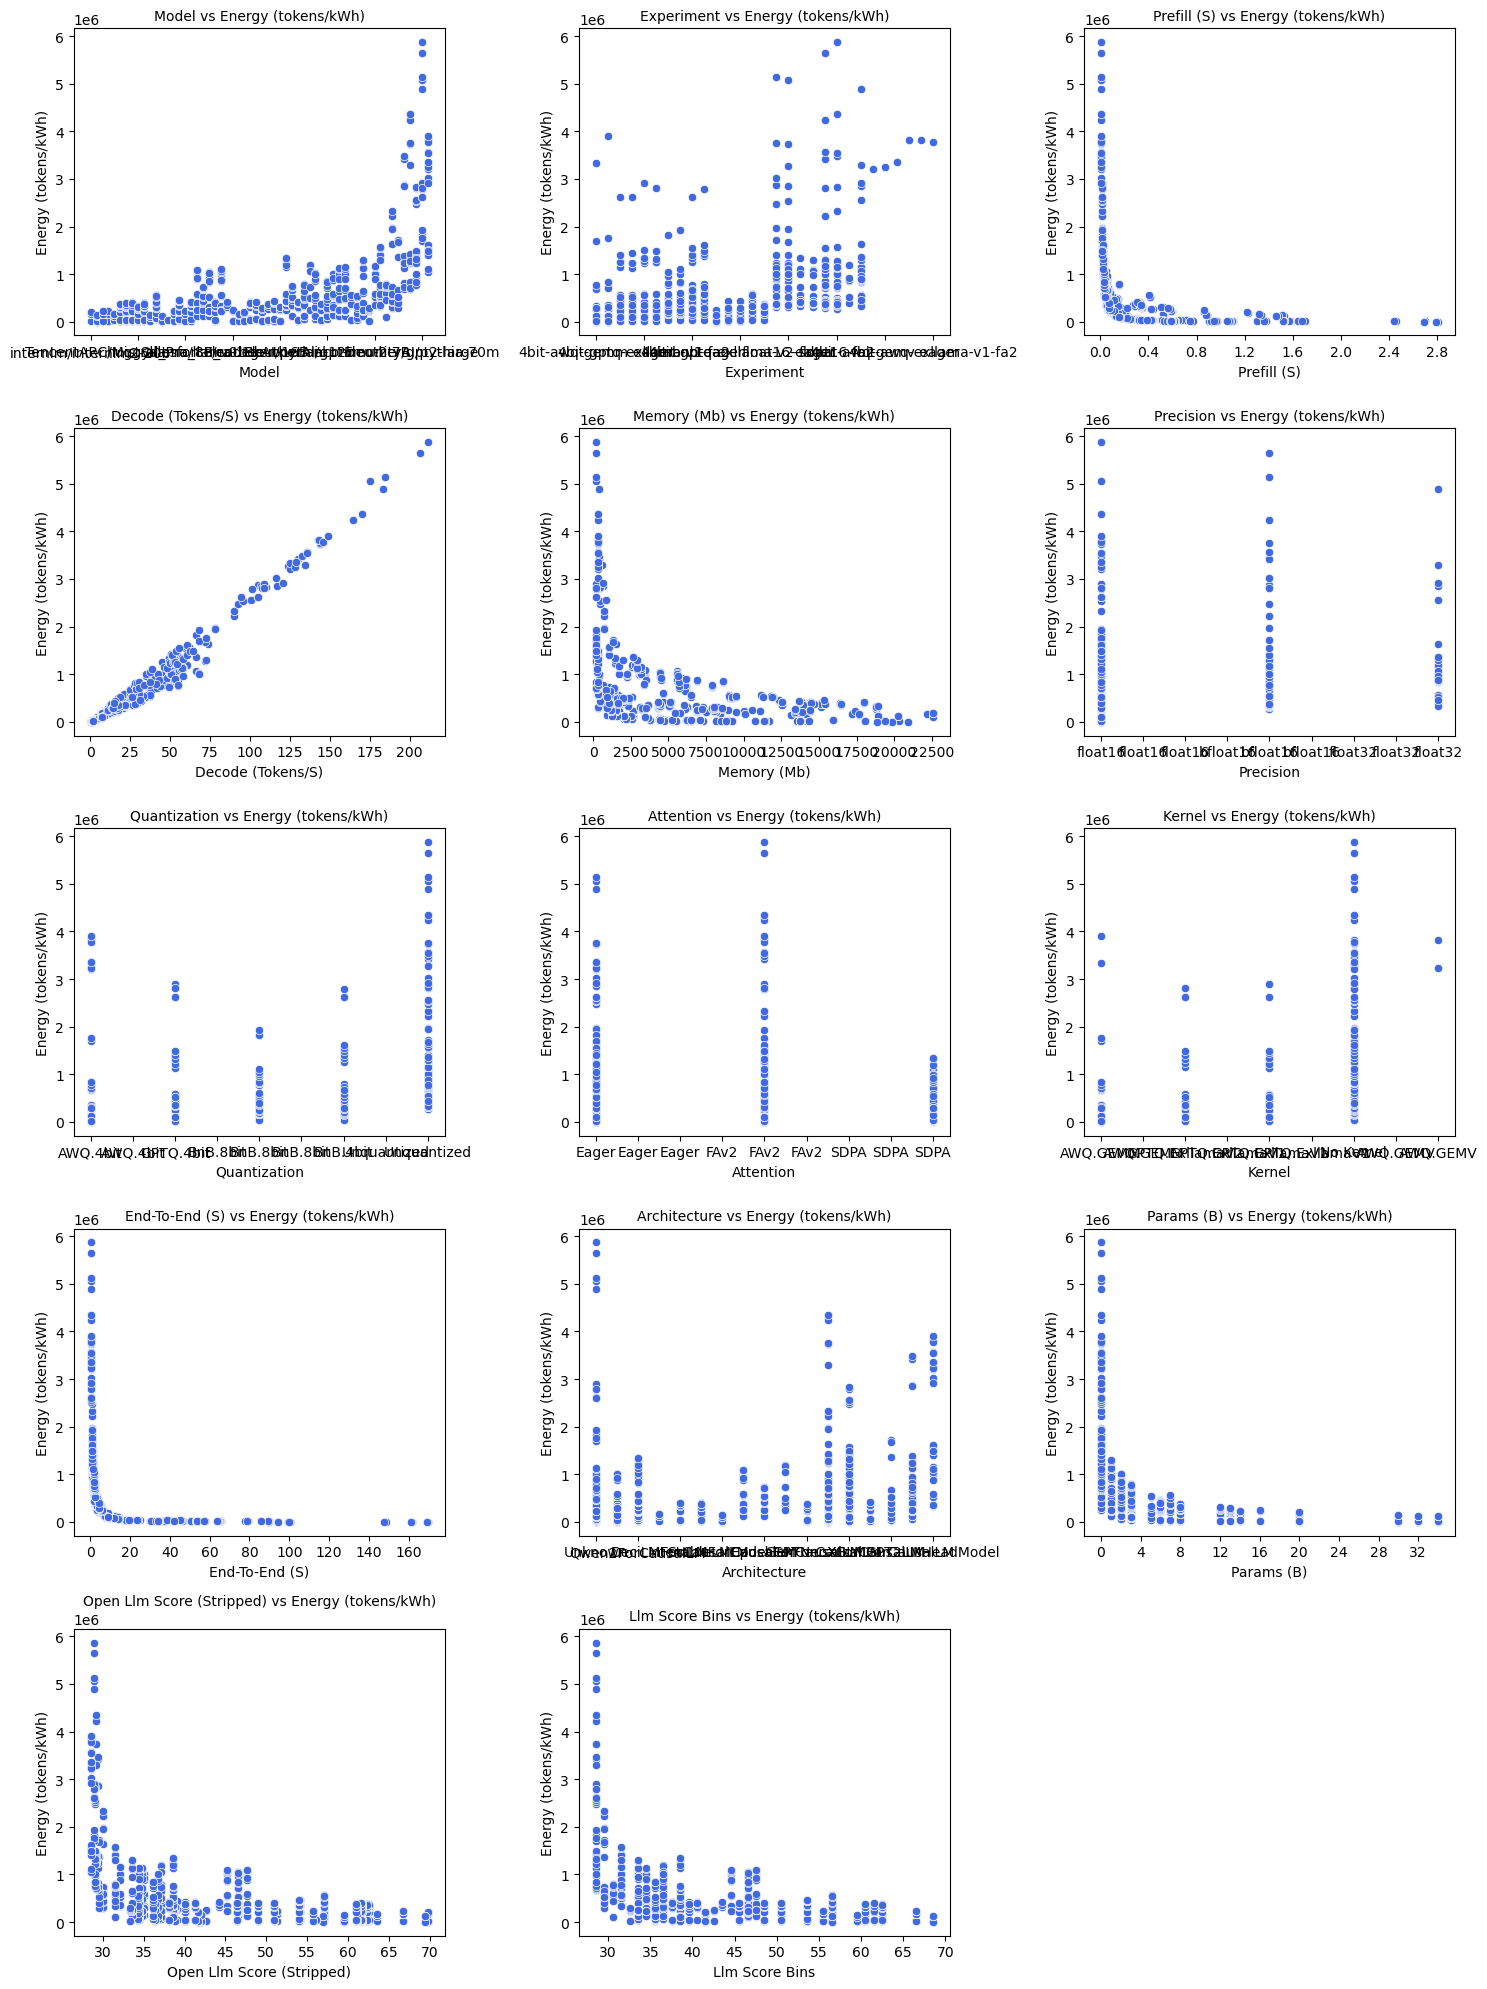

In [18]:
# Run this version with regression lines 
gg_scatterplots(data, y_variable='Energy (tokens/kWh)')

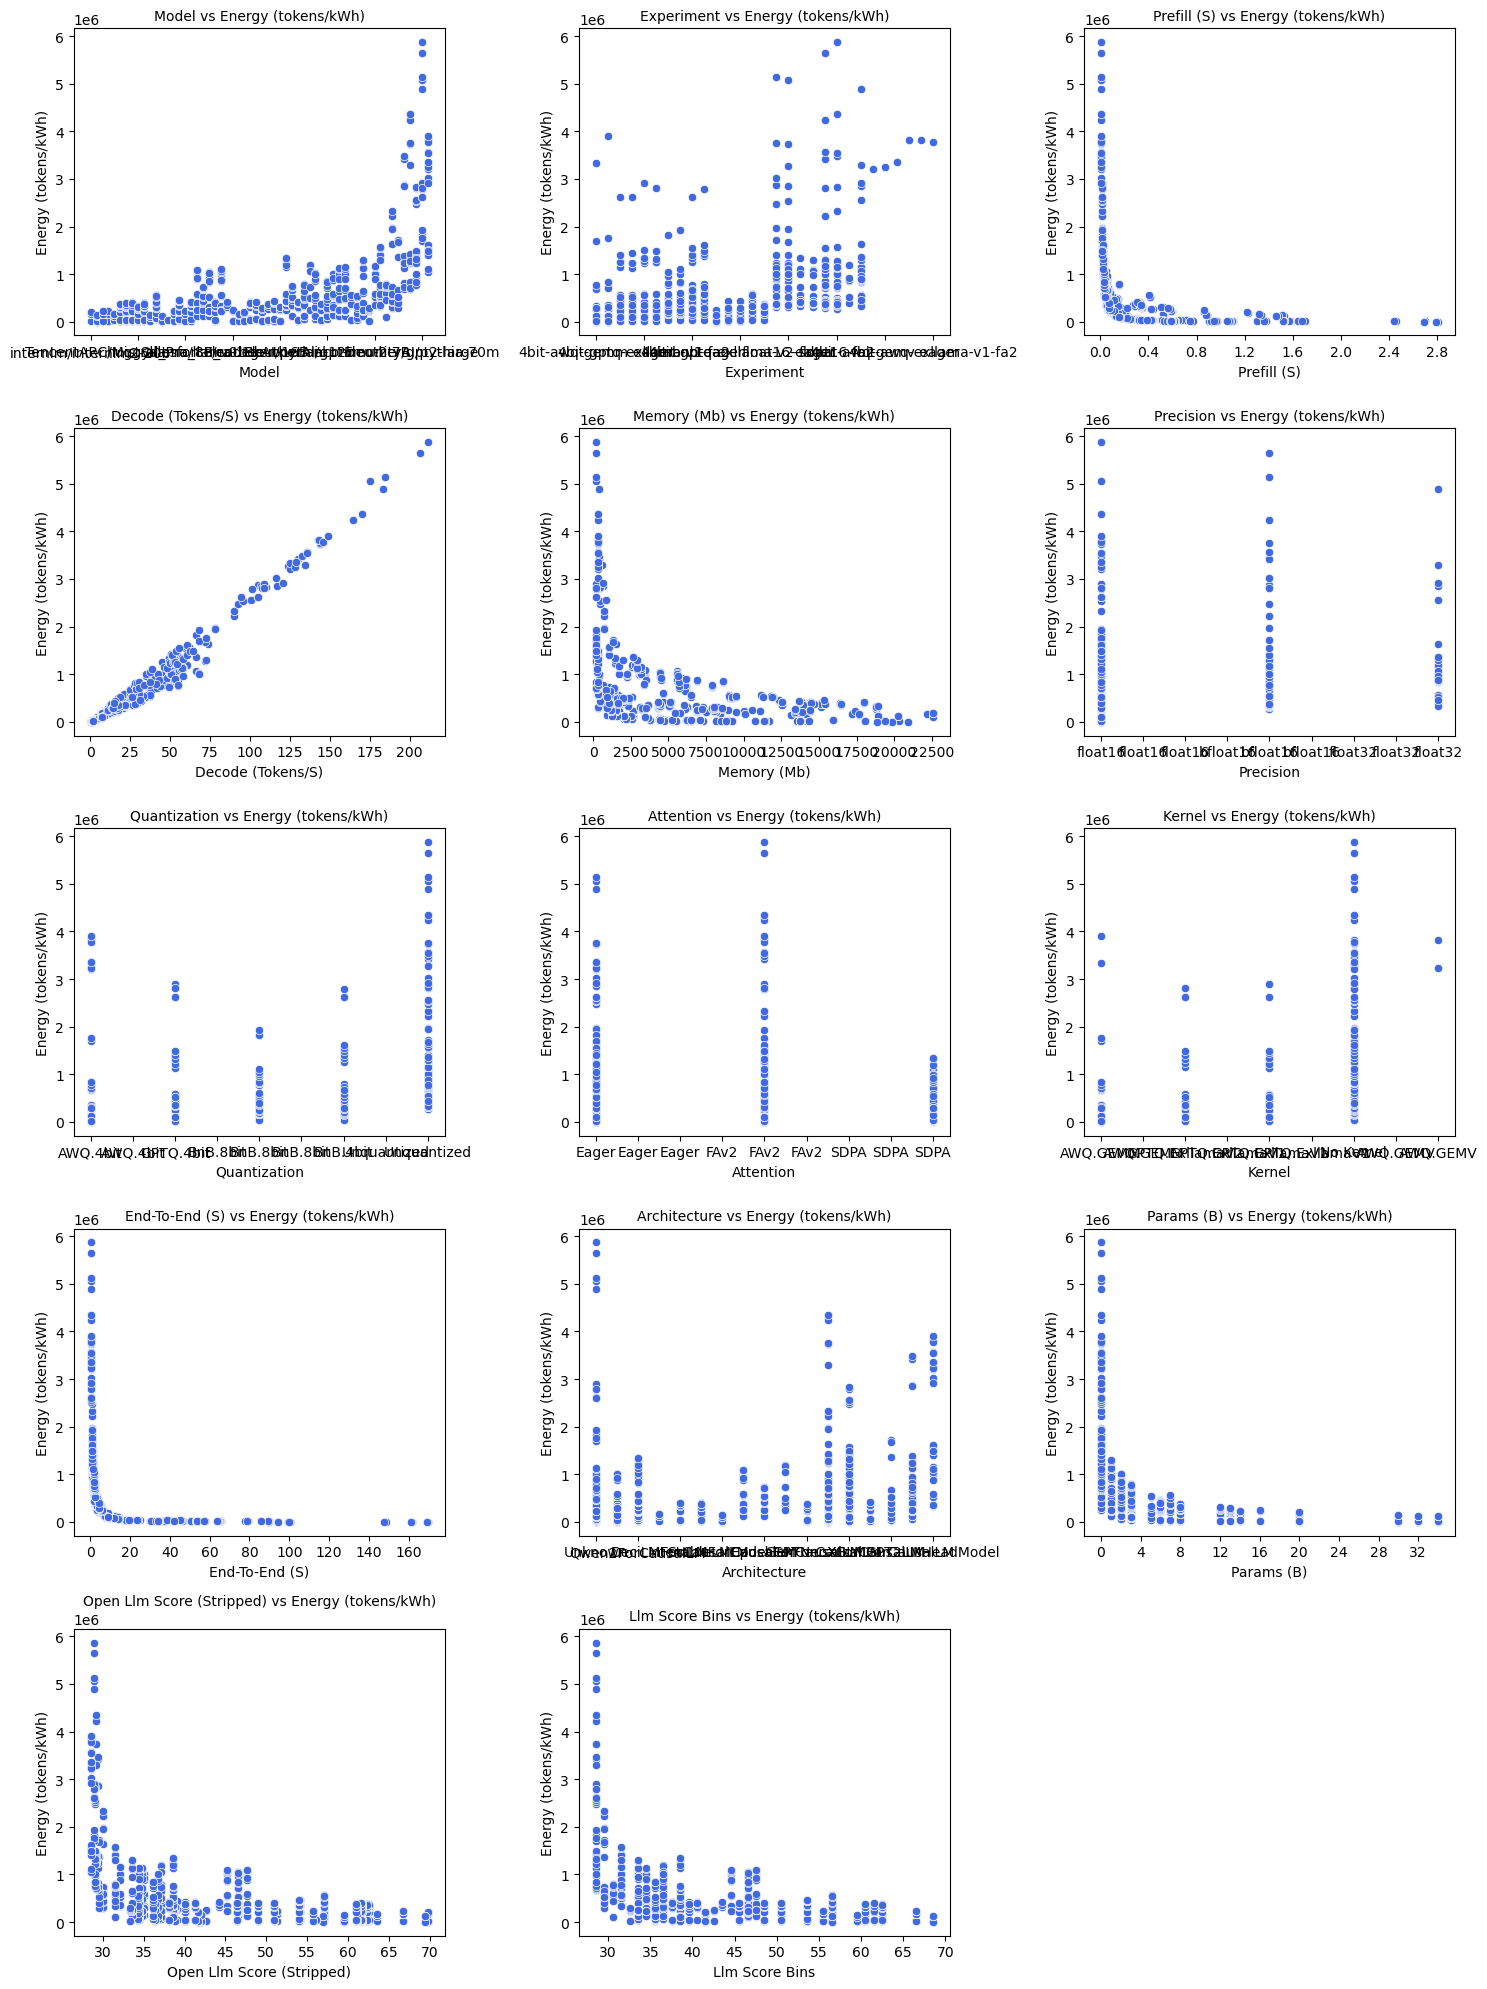

In [19]:
# Run without regression lines 
gg_scatterplots(data, y_variable='Energy (tokens/kWh)')

Pull out Open LLM Score (%), Energy Bins, Params Bins, Memory Bins, Backend from chart generation

Relationships by inspection:
1) Energy (tokens/kWh) negative log relationship with Open LLM Score %
2) Energy (tokens/kWh) negative log relationship with Params (B)
3) Energy (tokens/kWh) negative log relatipnship with Memory (MB)

Let's look at params plotted against Open LLM Score and Memory plotted against Open LLM Score

In [20]:
# limit data to only memory, open llm score, and params variables
data_limited = data[['Open LLM Score (stripped)', 'Memory (MB)', 'Params (B)']]
data_limited.head()

,Open LLM Score (stripped),Memory (MB),Params (B)
0,69.75,14169.857,20.0
1,69.75,14170.905,20.0
2,69.75,13753.433,20.0
3,69.75,13753.433,20.0
4,69.75,13753.432,20.0


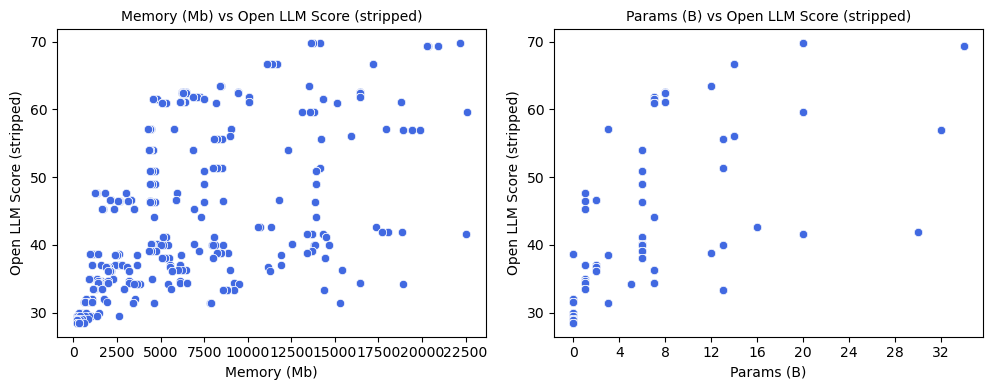

In [21]:
gg_scatterplots(data_limited, y_variable='Open LLM Score (stripped)')

Both variables share positive linear relationships with Open LLM Score %